### Evaluation of simulation measurements
* Generate measurements with OMNeT++
* Convert them to csv using `scavetool` (done below)
* Read and analyze using Python

For more details see this tutorial: https://docs.omnetpp.org/tutorials/pandas/

Evaluated service: Video streaming service with ad insertion

![omnet](../docs/omnet.png)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import call
%matplotlib inline

In [33]:
# call scavetool to generate the CSV
!{'scavetool x ../omnet-test/results/*.vec -o measurements.csv'}

Exported 38 vectors


In [34]:
# convenience functions for parsing numbers and arrays in csv correctly
def parse_if_number(s):
    try: 
        return float(s)
    except: 
        return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

# load measurements from results folder
results = pd.read_csv('measurements.csv', converters = {
                    'attrvalue': parse_if_number,
                    'binedges': parse_ndarray,
                    'binvalues': parse_ndarray,
                    'vectime': parse_ndarray,
                    'vecvalue': parse_ndarray})
results.head()

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
0,VideoFixed-0-20180803-14:39:40-9700,runattr,NaN,NaN,configname,VideoFixed,NaN,None,None
1,VideoFixed-0-20180803-14:39:40-9700,runattr,NaN,NaN,datetime,20180803-14:39:40,NaN,None,None
2,VideoFixed-0-20180803-14:39:40-9700,runattr,NaN,NaN,experiment,VideoFixed,NaN,None,None
3,VideoFixed-0-20180803-14:39:40-9700,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,None,None
4,VideoFixed-0-20180803-14:39:40-9700,runattr,NaN,NaN,iterationvars,None,NaN,None,None


In [35]:
# select the vectors recording tokenInDelay for analyzing the delay
delays = results[(results.type == 'vector') & (results.name == 'tokenInDelay')]
delays = delays[['module', 'name', 'vectime', 'vecvalue']]
delays.head()

,module,name,vectime,vecvalue
36,VideoFixed.C_P0,tokenInDelay,"[0.795874504566, 1.69443489305, 2.617658024521...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39,VideoFixed.C_T0,tokenInDelay,"[0.795874504566, 1.69443489305, 2.617658024521...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
41,VideoFixed.C_P1,tokenInDelay,"[1.725676610603, 2.119277180594, 2.86022210638...","[0.929802106037, 0.424842287544, 0.24256408186..."
43,VideoFixed.U_P0,tokenInDelay,"[1.725676610603, 2.860222106382, 4.70642666193...","[0.929802106037, 0.242564081861, 1.11176221101..."
45,VideoFixed.S_P0,tokenInDelay,"[2.119277180594, 9.362062655293, 19.1268803922...","[0.424842287544, 0.0102127942, 0.304541211592,..."


In [36]:
# convert into table with columns module, time, delay
def organize_delays(delays):
    organized_delays = {'module': [], 'time': [], 'tokenInDelay': []}
    for index, row in delays.iterrows():
        for i in range(row['vectime'].size):
            organized_delays['module'].append(row['module'][11:])    # drop "VideoFixed." prefix
            organized_delays['time'].append(row['vectime'][i])
            organized_delays['tokenInDelay'].append(row['vecvalue'][i])
    return pd.DataFrame(data=organized_delays)    

In [37]:
delays = organize_delays(delays)
delays.tail()

,module,time,tokenInDelay
21856,C_P2,3585.665994,1376.373167
21857,C_P2,3589.873331,1378.087820
21858,C_P2,3593.967126,1381.275156
21859,C_P2,3594.838334,1378.426218
21860,C_P2,3598.839743,1382.006573


Filter relevant delays: at inputs of each VNF and back at source
* cache_fwd: C_P0
* server: S_P0
* vid_opt: V_P0
* ad_ins: A_P0
* cache_bwd: C_T3 (after sync)
* user: U_P0

In [38]:
delays = delays[delays.module.isin(['C_P0', 'S_P0', 'V_P0', 'A_P0', 'C_T3', 'U_P0'])]
delays.head()

,module,time,tokenInDelay
0,C_P0,0.795875,0.0
1,C_P0,1.694435,0.0
2,C_P0,2.617658,0.0
3,C_P0,3.594664,0.0
4,C_P0,4.170184,0.0


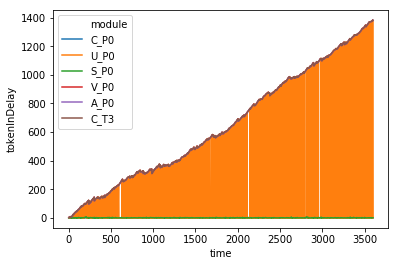

In [39]:
# shows increasing delay at VNFs after server and at user
sns.lineplot('time', 'tokenInDelay', hue='module', data=delays)
# TODO: improve visibility; plot queue lengths